# Sparse sensing documentation

## Mathematical theory

The fundamental intuition behind the concept of sparse sensing is that a great number of physical phenomena admit a sparse representation in some alternative basis [1](https://doi.org/10.1017/9781108380690). The intrinsic sparsity of a physical phenomenon also means that it is possible to dramatically decrease the amount of measurements without losing important information on the system [2](https://doi.org/10.48550/arXiv.math/0410542).


The goal of a Sensor Placement for Reconstruction (SPR) model is to find the solution of the following linear system:

\begin{equation}
    \tag{1}
	\mathbf{y} = \mathbf{C} \mathbf{x}
	\label{y_Cx}
\end{equation}

where $\mathbf{y} \subset \mathbb{R}^s$ is the measurement vector, $\mathbf{x} \subset \mathbb{R}^n$ represents the state of the system and $\mathbf{C} \subset \mathbb{R}^{s,n}$ is the measurement matrix. 


The objective is to minimize the amount of sensors needed, that is $ n \gg s$, which means that the matrix $ \mathbf{C} $ is not invertible and the linear system admits infinite solutions.  Moreover, the linear problem in Eq. (\ref{y_Cx}) is generally ill-conditioned. As a result, linear methods such as least-squares regression cannot be applied to find an acceptable solution.


However, if the system admits a sparse representation in a new basis, we can consider that $ \mathbf{x} \approx \mathbf{U}_{q} \mathbf{a}_q$ where $\mathbf{U}_q \subset \mathbb{R}^{n,q}$ represents the $q$-order truncation of the transforming basis and $\mathbf{a}_q$ is the projection of $\mathbf{x}$ onto the new truncated basis.


Depending on the system considered, a different number of decomposition techniques can be applied to recover the new basis from the data. An obvious choice is to use the Proper Orthogonal Decomposition (POD) [3](https://doi.org/10.1146/annurev.fl.25.010193.002543), also known as Principal Component Analysis (PCA) or Karhunen-Loeve transform (KLT), because it guarantees that the $q$-order truncation is the one that minimizes the $l_2$ norm reconstruction error. The POD can be achieved by applying the Singular Value Decomposition (SVD) to the dataset:


\begin{equation}
	\mathbf{X} = \mathbf{U} \mathrm{\boldsymbol{\Sigma}} \mathbf{V}^T
    \label{eq_SVD}
\end{equation}


where $\mathbf{X} \subset \mathbb{R}^{n,p}$ represents the data matrix to be decomposed, $\mathbf{U} \subset \mathbb{R}^{n,p}$ and $\mathbf{V} \subset \mathbb{R}^{p,p}$ are matrices which form an orthonormal basis for the column and row spaces of $\mathbf{X}$, and $\mathrm{\boldsymbol{\Sigma}} \subset \mathbb{R}^{p,p}$ is the diagonal matrix which contains the singular values of $\mathbf{X}$. The singular values are the square root of the eigenvalues of the correlation matrix $\mathbf{S} = \mathbf{X}^T \mathbf{X}$, and they express the amount of variance that each column (mode) of $\mathbf{U}$ is able to capture with respect to the original data matrix.  


If we assemble $p$ vectors $\mathbf{x}$ as column vectors of a data matrix $\mathbf{X}$, we can then use the SVD to find the transforming basis $\mathbf{U}_q$ by discarding the last $p-q$ columns of $\mathbf{U}$. 


By introducing $ \mathbf{x} = \mathbf{U}_{q} \mathbf{a}_q$, the linear system in Eq. (\ref{y_Cx}) can then be written as:

\begin{equation}
    \tag{2}
	\mathbf{y} = \mathrm{\boldsymbol{\Theta}} \mathbf{a}_q
    \label{y_thetax}
\end{equation}

where $ \mathrm{\boldsymbol{\Theta}} = \mathbf{C} \mathbf{U}_q$. In order to find a solution for Eq. (\ref{y_thetax}), the matrix $\mathbf{C}$ has to be constructed such that $\mathrm{\boldsymbol{\Theta}}$ is as well-conditioned as possible. This objective can be reached by making sure that $\mathbf{C}$ is incoherent with respect to $\mathbf{U}_q$, which means that the rows of $\mathbf{C}$ should not be correlated with the columns of  $\mathbf{U}_q$ [4](https://doi.org/10.1109/MSP.2007.914731). 

### Optimal placement using QR decomposition with column pivoting
A popular approach to construct the measurement matrix is to use random sampling. This technique is computationally inexpensive, and a random measurement has a high probability of being incoherent with respect to the transforming basis [4](https://doi.org/10.1109/MSP.2007.914731). However, this technique does not produce an optimized placement of sensors, thus the number of sensors required is far from the theoretical minimum.


Another technique to construct the measurement matrix is to select the sensors' position based on the QR decomposition with column pivoting (QRCP) [5](https://doi.org/10.1109/MCS.2018.2810460). The QRCP is a decomposition technique in which a matrix $\mathbf{A}\subset \mathbb{R}^{q,n}$ is factorized into an orthogonal matrix $\mathbf{Q} \subset \mathbb{R}^{q,q}$ and an upper rectangular matrix $\mathbf{R}\subset \mathbb{R}^{q,n}$:

\begin{equation}
	\mathbf{A}\mathbf{P} = \mathbf{Q}\mathbf{R}
\end{equation}

The matrix $\mathbf{P}$ is a permutation matrix which is chosen so that the diagonal elements of $\mathbf{R}$ are not increasing. QRCP is usually employed as a rank revealing method. In our case, the pivots are used to construct the measurement matrix from the transforming basis:

\begin{equation}
	\mathbf{U}_q^T \mathbf{C}^T = \mathbf{Q}\mathbf{R}
    \label{optimal_C}
\end{equation}

The QRCP is able to provide $q$ sensors which best sample the transforming basis $\mathbf{U}_q$. 


### Optimal placement using the greedy entropy maximization algorithm

The optimal placement problem can be defined as finding the set of sensors that convey the maximum amount of information on the transforming basis $\mathbf{U}_q$. 

In the context of information theory, the information content associated with an event $X = x$, where $X$ represents a random variable and $x$ a specific value assumed by $X$, is defined as:

\begin{equation}
    I(X=x) = -\log p(x)
\end{equation}


From this, the expected information content (entropy) of a random variable $X$ is equal to:

\begin{equation}
	H(X) = -\sum_{x} p(x) \log p(x)
\end{equation}

Our goal is then to find the set of $n$ sensors that maximize the joint entropy:

\begin{equation}
    H(X_1, X_2, \dots, X_n) = - \sum_{x_n} \dots \sum_{x_2}\sum_{x_1} p(x_1, x_2, \dots, x_n) \log p(x_1, x_2, \dots, x_n)
\end{equation}

However, there are a couple of problems associated with this goal. The first is that to find the maximum joint entropy we need to perform a combinatorial search through the all possible set of $n$ sensors, which is infeasible. The second problem is that we need a way to represent the joint probability from the data at hand. 


The first problem is solved by applying a greedy maximization algorithm. This means that the algorithm searches first the sensor associated with the maximum entropy. Then, the second sensor is selected as the one that maximizes the entropy of the joint distribution with the first sensor. The search is continued until we reach the desired number of sensors.

The second problem is tackled by approximating the joint probability distribution as a joint gaussian distribution [6](http://jmlr.org/papers/v9/krause08a.html).  The gaussian approximation allows us to compute the differential conditional entropy of the joint gaussian distribution :

\begin{equation}
    H(y|A) = \frac{1}{2} \log \sigma^2_{y|A} + \frac{1}{2}(\log(2 \pi) + 1)
\end{equation}

\begin{equation}
    \sigma^2_{y | A} = \sigma^2_{y} - \Sigma_{yA} \Sigma_{AA}^{-1} \Sigma_{Ay}
\end{equation}

where the subscripts $A$ and $y$ denotes the set of sensors already selected and the sensor to add. If $\Sigma$ is the covariance matrix of the set containing $A$ and $y$, then:

\begin{equation}
    \Sigma = 
    \begin{bmatrix}
        \Sigma_{AA} & \Sigma_{Ay} \\
        \Sigma_{yA} &  \sigma^2_{y}
    \end{bmatrix}
\end{equation}


### Prediction using Ordinary Least Squares and Constrained Ordinary Least Squares

The linear system in Eq. \ref{y_thetax} can be solved using Ordinary Least Squares (OLS). This is equivalent to find the solution $\mathbf{a}^*$ that minimizes the $l_2$ norm distance:

\begin{equation}
    \mathbf{a}^* = \underset{\mathbf{a}}{\mathrm{argmin}} || \mathbf{y} - \boldsymbol{\Theta} \mathbf{a}||_2
\end{equation}

If the data matrix contains only thermo-chemical features (temperature and species mass fractions), we also know that the solution has to be positive everywhere. This constraint can be introduced while solving the linear system: 


\begin{align}
\mathbf{a}^* = \underset{\mathbf{a}}{\textrm{argmin}}  & \  || \mathbf{y} - \boldsymbol{\Theta} \mathbf{a}||_2 \\
\textrm{s.t.}  & \  \mathbf{U}_r \mathbf{a} > 0
\end{align}


## Example

The first cell is used to download the dataset from zenodo using the ```zenodo_get ``` command. This command can be installed via:
```console
pip install zenodo_get
```
Otherwise, the dataset can be downloaded directly from [zenodo](https://www.zenodo.org/record/7786311).

In [ ]:
import zenodo_get

! zenodo_get -d 10.5281/zenodo.7786311
! unzip DT_dataset.zip

Here we import some libraries and we create the data matrix `X` that contains the 45 simulations.

In [1]:
import glob
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

def read_simulation(filepath):
    sim = np.array(pd.read_csv(filepath))
    xyz = np.array(sim[:,1:4])

    column = np.empty((n_3D, ))
    for i, f in enumerate(features):
        if xyz.shape[0] != n_cells_3D:
            column[i*n_cells_3D:(i+1)*n_cells_3D] = griddata(xyz, sim[:,4+i], xyz_25, method='nearest')
        else:
            column[i*n_cells_3D:(i+1)*n_cells_3D] = sim[:,4+i]

    return column

path = './DT_dataset'

P_df = pd.read_csv(f'{path}/cases_parameters.csv')
P = np.array(P_df.iloc[:,2:])
m = P.shape[0]

features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
n_features = len(features)

# The simulations with different inlet diameter use different grids.
# We interpolate them on the coarsest grid, which is the one for D=25mm.

filepath = glob.glob(f'{path}/Numerical_data/Case6_*')
xyz_25 = np.array(pd.read_csv(filepath[0]).iloc[:,1:4])
n_cells_3D = xyz_25.shape[0]

n_3D = n_features*n_cells_3D
X_3D = np.empty((n_3D,m))
for i in range(P_df.shape[0]):
    filepath =  glob.glob(f'{path}/Numerical_data/Case{P_df.iloc[i,1]}_*')
    X_3D[:,i] = read_simulation(filepath[0])
    print(f'Simulation {i+1}/{m}', end='\r', flush=True)

To speed-up the calculations, we consider only the data on the $y=0$ plane. Skip this cell if you want to calculate the entire
3D solution.

In [14]:
import pyvista as pv

# read the mesh using Pyvista
mesh = pv.read(f'{path}/grid.vtu')

for i in range(m):
    print(f'Storing simulation {i+1}/{m}', end='\r', flush=True)
    for j in range(n_features):
        mesh[f'{i}/{j}'] = X_3D[j*n_cells_3D:(j+1)*n_cells_3D, i]


plane = mesh.ctp(pass_cell_data=True).slice(normal='y', origin=(0,1e-3,0), progress_bar=True, generate_triangles=True)

xyz = plane.cell_centers().points
n_cells = plane.n_cells
n = n_features*n_cells
X = np.empty((n,m))

for i in range(m):
    print(f'Retrieving simulation {i+1}/{m}', end='\r', flush=True)
    for j in range(n_features):
        X[j*n_cells:(j+1)*n_cells, i] = plane.cell_data[f'{i}/{j}']

Slicing: 100%|██████████[00:16<00:00]


(64036, 3)
64036


## Optimal sensor placement

In this cell, we use the function `optimal_placement()` to compute the optimal sensor placement matrix C using the QRCP algorithm.

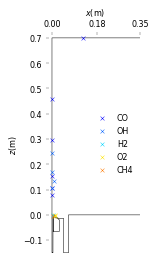

In [15]:
from sparse_sensing import SPR
import matplotlib as mpl
import matplotlib.pyplot as plt

def sample_cmap(x):
    return plt.cm.jet((np.clip(x,0,1)))

def plot_sensors(xyz_sensors, features, mesh_outline):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(mesh_outline[:,0], mesh_outline[:,1], c='k', lw=0.5, zorder=1)
    
    features_unique = np.unique(xyz_sensors[:,3])
    colors = np.zeros((features_unique.size,4))
    for i in range(colors.shape[0]):
        colors[i,:] = sample_cmap(features_unique[i]/len(features))
        
    for i, f in enumerate(features_unique):
        mask = xyz_sensors[:,3] == f
        ax.scatter(xyz_sensors[:,0][mask], xyz_sensors[:,2][mask], color=colors[i,:], 
                   marker='x', s=15, lw=0.5, label=features[int(f)], zorder=2)

    
    ax.set_xlabel('$x (\mathrm{m})$', fontsize=8)
    ax.set_ylabel('$z (\mathrm{m})$', fontsize=8)
    eps = 1e-2
    ax.set_xlim(-eps, 0.35)
    ax.set_ylim(-0.15,0.7+eps)
    ax.set_aspect('equal')
    ax.legend(fontsize=8, frameon=False, loc='center right')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    wid = 0.3
    ax.xaxis.set_tick_params(width=wid)
    ax.yaxis.set_tick_params(width=wid)
    ax.set_xticks([0., 0.18, 0.35])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.show()

i_test = [0, 21, 27, 38] # index of the testing simulations

P_train = np.delete(P, i_test, axis=0)
P_test = P[i_test, :]

X_train = np.delete(X, i_test, axis=1)
X_test = X[:, i_test]

spr = SPR(X_train, n_features, xyz) # Create the spr object

# Compute the optimal measurement matrix using qr decomposition
n_sensors = 14
C_qr = spr.optimal_placement(select_modes='number', n_modes=n_sensors)

# Get the sensors positions and features
xyz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_qr[i,:])
    xyz_sensors[i,:3] = xyz[index % n_cells, :]
    xyz_sensors[i,3] = index // n_cells

mesh_outline = np.genfromtxt('../data/ROM/mesh_outline.csv', delimiter=',', skip_header=1)

plot_sensors(xyz_sensors, features, mesh_outline)



In this cell, we use the same function `optimal_placement()` but we employ the greedy entropy maximization algorithm to find the optimal sensors.

---------------------------------------------------------------------- 
 # sensors  sigma^2 y  sigma^2 y|a    Htot    
 
    1       4.00e+00       -          -    
    2       1.92e+00   1.89e+00   1.74e+00 
    3       1.89e+00   1.78e+00   3.44e+00 
    4       1.29e+00   1.17e+00   4.94e+00 
    5       7.14e-01   5.65e-01   6.07e+00 
    6       5.59e-01   4.25e-01   7.07e+00 
    7       2.65e-01   1.26e-01   7.45e+00 
    8       1.37e-01   1.26e-01   7.83e+00 
    9       3.83e-01   8.04e-02   7.99e+00 
    10      1.62e-01   3.20e-02   7.69e+00 
    11      1.62e-01   9.52e-06   3.32e+00 
    12      1.62e-01   3.01e-04   6.89e-01 
    13      5.59e-01   1.72e-05  -3.38e+00 
    14      6.90e-01   1.99e-05  -7.37e+00 


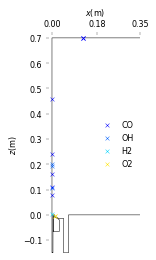

In [16]:
# Compute the optimal measurement matrix using gem decomposition
n_sensors = 14

C_gem = spr.optimal_placement(calc_type='gem', n_sensors=n_sensors, n_modes=99.5, verbose=True)

# Get the sensors positions and features
xyz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_gem[i,:])
    xyz_sensors[i,:3] = xyz[index % n_cells, :]
    xyz_sensors[i,3] = index // n_cells

plot_sensors(xyz_sensors, features, mesh_outline)

The placement and choice of sensors is similar to the QRCP choice. However, the advantage of the GEM algorithm is that we can select an arbitrary number of sensors, and we can enforce the minimum distance between them. In the next cell we use the GEM algorithm to find the optimal set of 20 sensor spaced at least 5 cm apart.

---------------------------------------------------------------------- 
 # sensors  sigma^2 y  sigma^2 y|a    Htot    
 
    1       4.00e+00       -          -    
    2       1.92e+00   1.89e+00   1.74e+00 
    3       1.13e+00   7.64e-01   3.02e+00 
    4       6.23e-01   5.94e-01   4.18e+00 
    5       6.41e-01   4.63e-01   5.21e+00 
    6       1.37e-01   1.23e-01   5.58e+00 
    7       1.24e-01   1.11e-01   5.91e+00 
    8       1.62e-01   9.30e-02   6.14e+00 
    9       2.77e-01   3.69e-02   5.90e+00 
    10      5.08e-02   2.33e-02   5.45e+00 
    11      9.95e-02   1.50e-06   1.57e-01 
    12      1.14e-01   3.94e-06  -4.65e+00 
    13      7.22e-02   5.54e-06  -9.28e+00 
    14      9.19e-02   4.22e-06  -1.40e+01 
    15      9.92e-03   1.11e-06  -1.95e+01 
    16      9.34e-03   4.67e-06  -2.42e+01 
    17      1.09e-02   5.17e-06  -2.89e+01 
    18      1.44e-03   5.50e-08  -3.58e+01 
    19      7.61e-04   8.27e-09  -4.37e+01 
    20      5.53e-02   3.03e-06  -4.86e+01 

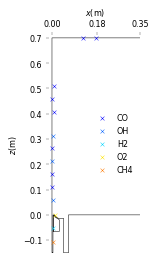

In [17]:
C_gem = spr.optimal_placement(calc_type='gem', n_sensors=20, d_min=0.05, n_modes=99.5, verbose=True)

# Get the sensors positions and features
xyz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_gem[i,:])
    xyz_sensors[i,:3] = xyz[index % n_cells, :]
    xyz_sensors[i,3] = index // n_cells

plot_sensors(xyz_sensors, features, mesh_outline)

## Sparse Placement for Reconstruction

In this cell, we use the C matrix to sample a test case, then we use the `SPR()` function to predict the state of the system given few (14) measurements. 

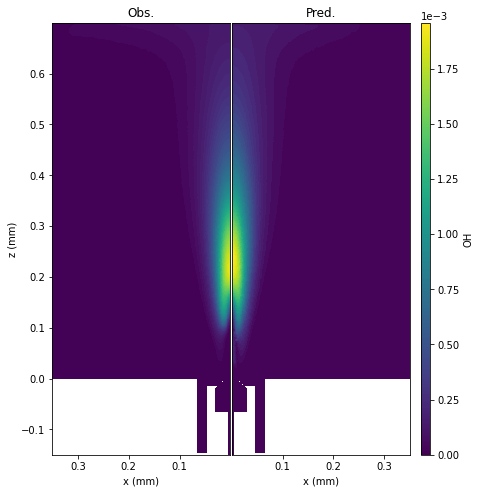

In [18]:
import pyvista as pv

def plot_comparison_3D(mesh, zs, normal, origin, axis, feature, cmap='viridis'):
    n_cases = len(zs)
    cases = ['Obs.', 'Pred.']  
    for i, case in enumerate(cases):
        mesh[case] = zs[i]
        
    plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)
    
    vmin = np.min([plane[cases[0]].min(), plane[cases[1]].min()])
    vmax = np.max([plane[cases[0]].max(), plane[cases[1]].max()])

    x = plane.points
    tri = plane.faces.reshape((-1,4))[:, 1:]
    
    fig, axs = plt.subplots(ncols=n_cases, figsize=(5.4, 6))
    levels = 64

    axis_labels = ['x', 'y', 'z']
    fig.subplots_adjust(bottom=0., top=1., left=0, right=.925, wspace=0.0, hspace=0.05)

    for i, ax in enumerate(axs):
        if i == 0:
            ax.invert_xaxis()
        
        cs = ax.tricontourf(x[:,axis[0]], x[:,axis[1]], tri, plane[cases[i]], cmap=cmap,
                        levels=levels, vmin=vmin, vmax=vmax)
        
        ax.set_aspect('equal')
        ax.set_xlabel(f'{axis_labels[axis[0]]} (mm)')
        ax.set_title(cases[i])

        if i > 0:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_ylabel(f'{axis_labels[axis[1]]} (mm)')
    
    
    ax_bounds = axs[1].get_position().bounds
    cb_ax = fig.add_axes([0.95, ax_bounds[1], 0.025, ax_bounds[3]])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        cax=cb_ax, orientation='vertical', label=feature)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((0, 4))
    cb_ax.yaxis.set_offset_position('left')
    
    plt.show()

def plot_comparison(plane, zs, feature, cmap='viridis'):
    n_cases = len(zs)
    cases = ['Obs.', 'Pred.']  
    for i, case in enumerate(cases):
        plane[case] = zs[i]
        
    plane = plane.ctp()
    
    vmin = np.min([plane[cases[0]].min(), plane[cases[1]].min()])
    vmax = np.max([plane[cases[0]].max(), plane[cases[1]].max()])

    extent_min = [-0.2, -0.2, 0.1]
    extent_max = [0.2, 0.2, 0.5]

    x = plane.points
    tri = plane.faces.reshape((-1,4))[:, 1:]
    
    fig, axs = plt.subplots(ncols=n_cases, figsize=(5.4, 6))
    levels = 64

    axis_labels = ['x', 'y', 'z']
    fig.subplots_adjust(bottom=0., top=1., left=0, right=.925, wspace=0.0, hspace=0.05)

    for i, ax in enumerate(axs):
        if i == 0:
            ax.invert_xaxis()
        
        cs = ax.tricontourf(x[:,0], x[:,2], tri, plane[cases[i]], cmap=cmap,
                        levels=levels, vmin=vmin, vmax=vmax)
        
        ax.set_aspect('equal')
        ax.set_xlabel(f'{axis_labels[0]} (mm)')
        ax.set_title(cases[i])

        if i > 0:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_ylabel(f'{axis_labels[2]} (mm)')
    
    
    ax_bounds = axs[1].get_position().bounds
    cb_ax = fig.add_axes([0.95, ax_bounds[1], 0.025, ax_bounds[3]])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        cax=cb_ax, orientation='vertical', label=feature)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((0, 4))
    cb_ax.yaxis.set_offset_position('left')
    
    plt.show()
    
# Sample a test simulation using the optimal qr matrix
y_qr = np.zeros((n_sensors,3))
y_qr[:,0] = C_qr @ X_test[:,3]

for i in range(n_sensors):
    y_qr[i,2] = np.argmax(C_qr[i,:]) // n_cells

# Fit the model and predict the low-dim vector (ap) and the high-dim solution (xp)
spr.fit()
spr.train(C_qr)
Ap, Ap_sigma = spr.predict(y_qr)
Xp_test = spr.reconstruct(Ap)

# read the mesh using Pyvista
mesh = pv.read(f'{path}/grid.vtu')

# Select the feature to plot
str_ind = 'OH'
ind = features.index(str_ind)

x_test = X_test[ind*n_cells:(ind+1)*n_cells, 3]
xp_test = Xp_test[ind*n_cells:(ind+1)*n_cells, 0]

plot_comparison(plane, [x_test, xp_test], str_ind)

We can improve the prediction by enforcing the costraint that $\mathbf{x} > 0 $ everywhere. This is done by using the `'COLS'` method.

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Nov 03 02:48:11 PM: Your problem has 9 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 03 02:48:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 03 02:48:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 03 02:48:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 03 02:48:11 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 03 02:48:11 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> 

(CVXPY) Nov 03 02:48:15 PM: Applying reduction ECOS
(CVXPY) Nov 03 02:48:18 PM: Finished problem compilation (took 7.046e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 03 02:48:18 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 03 02:49:25 PM: Problem status: optimal
(CVXPY) Nov 03 02:49:25 PM: Optimal value: 1.799e+01
(CVXPY) Nov 03 02:49:25 PM: Compilation took 7.046e+00 seconds
(CVXPY) Nov 03 02:49:25 PM: Solver (including time spent in interface) took 6.707e+01 seconds


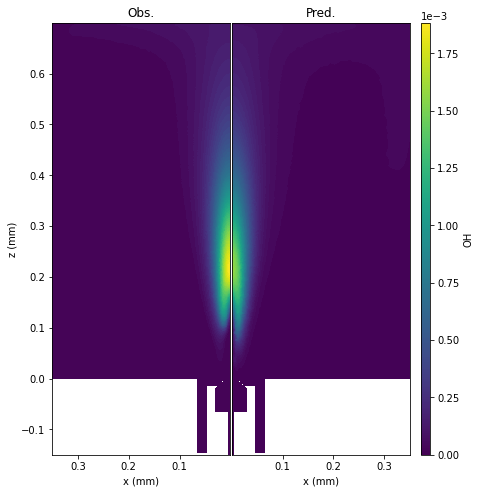

In [19]:
# features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
limit_min = np.array([0., 0., 0., 0., 0., 0., 0., 0., 200.])
limit_max = np.array([1., 1., 1., 1., 1., 1., 1., 1., 3000.])

# Fit the model and predict the low-dim vector (ap) and the high-dim solution (xp)
spr.train(C_qr, method='COLS', limits=[limit_min, limit_max], verbose=True, abstol=1e-2)
Ap, Ap_sigma = spr.predict(y_qr)
Xp_test = spr.reconstruct(Ap)

# Select the feature to plot
str_ind = 'OH'
ind = features.index(str_ind)

x_test = X_test[ind*n_cells:(ind+1)*n_cells, 3]
xp_test = Xp_test[ind*n_cells:(ind+1)*n_cells, 0]

plot_comparison(plane, [x_test, xp_test], str_ind)

The quality of the model depends also on the choice of the scaling method. The scaling methods implemented are: `'std'`, `'none'`, `'pareto'`, `'vast'`, `'range'`, `'level'`, `'max'`, `'variance'`, `'median'`, `'poisson'`, `'vast_2'`, `'vast_3'`, `'vast_4'`, `'l2-norm'`. Their mathematical definition is reported in [7](https://pcafold.readthedocs.io/en/latest/user/data-preprocessing.html).

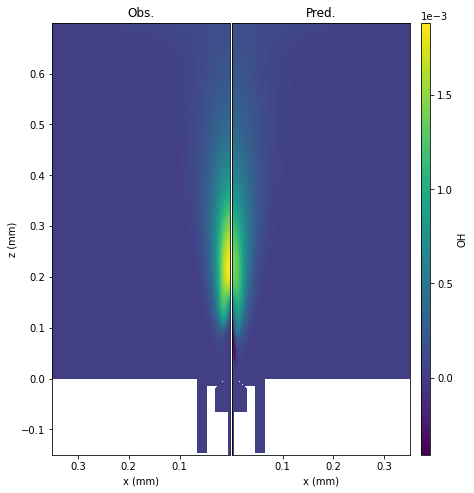

In [20]:
scale_type = 'range'
C_qr = spr.optimal_placement(select_modes='number', n_modes=n_sensors, scale_type=scale_type)
y_qr = np.zeros((n_sensors,3))
y_qr[:,0] = C_qr @ X_test[:,3]

for i in range(n_sensors):
    y_qr[i,2] = np.argmax(C_qr[i,:]) // n_cells

spr.fit(scale_type=scale_type)
spr.train(C_qr)
Ap, Ap_sigma = spr.predict(y_qr)
Xp_test = spr.reconstruct(Ap)

str_ind = 'OH'
ind = features.index(str_ind)

x_test = X_test[ind*n_cells:(ind+1)*n_cells, 3]
xp_test = Xp_test[ind*n_cells:(ind+1)*n_cells, 0]

plot_comparison(plane, [x_test, xp_test], str_ind)